In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IMDB
from torchtext import data
from torchtext.vocab import GloVe

import os
import json
import time
import random
import copy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from IPython.display import Image

from seq_label import SeqLabel


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Common Parameters

In [0]:
batch_size = 16
# Percentage of training data
split_ratio = 0.8
learning_rate = 0.001
# vocabulary size to embed input (GloVe output dim)
embed_dim = 300

## IMDb data

In [4]:
from imdb import IMDB_dataset

imdb = IMDB_dataset(split_ratio, SEED)
imdb.load(verbose = True)
imdb.build_vocab(embed_dim)
train_loader, valid_loader, test_loader = imdb.create_data_loader(batch_size, 
                                                                  device)
vocab_len = len(imdb.TEXT.vocab)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 10.2MB/s]
.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

Training data size:    20000
Validation data size:  5000
Test data size:        25000


.vector_cache/glove.6B.zip: 862MB [00:43, 19.8MB/s]                           
100%|█████████▉| 399506/400000 [00:51<00:00, 7782.97it/s]

# LSTM

#### LSTM Parameters

In [0]:
# Number of hidden nodes
hidden_dim = 128
# Number of output nodes
output_dim = 1
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = True

### Our implementation

In [45]:
## Our implementation
from seq_label import LSTMSeqLabel

# Initializing model
model = LSTMSeqLabel(vocab_len, embed_dim, hidden_dim, output_dim, 
                      imdb.pretrained_weights, layers, bidirectional,
                      layernorm)
model.to(device)

print('Model parameters: ', model.count_parameters())

# Initializing optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.BCEWithLogitsLoss()

# Initializing task
task = SeqLabel(model, optimizer, loss_criterion, device)

# Training
freq = 5    # epoch interval to calculate F1 score and save models
out_dir = "/content/drive/My Drive/colab/hpo/seq_label/lstm/"

Model parameters:  442113


In [0]:
model, stats = task.train(100, train_loader, valid_loader, freq, out_dir)

In [0]:
# # To test a saved model
# task.model.load(os.path.join(out_dir, 'model_epoch_10.pkl'))

In [0]:
# Testing
f1_test = task.evaluate(test_loader, verbose=True)
print('F1 score: ', f1_test)

### PyTorch implementation

In [0]:
## PyTorch implementation

from seq_label import PyTorchBaseline

# Initializing model
model = PyTorchBaseline(vocab_len, embed_dim, hidden_dim, output_dim, 
                       imdb.pretrained_weights, layers, bidirectional)
model.to(device)

print('Model parameters: ', model.count_parameters())

# Initializing optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.BCEWithLogitsLoss()

# Initializing task
task = SeqLabel(model, optimizer, loss_criterion, device)

# Training
freq = 5    # epoch interval to calculate F1 score and save models
out_dir = "/content/drive/My Drive/colab/hpo/seq_label/lstm/"

Model parameters:  440577


### Training

In [0]:
model, stats = task.train(epochs, train_loader, valid_loader, freq, out_dir)

Beginning training model with 440577 parameters


Epoch #1: Average loss is 0.6925819813251496
Epoch #1: Train F1 is 0.0825618741734366
Epoch #1: Validation F1 is 0.587151841868823
Time taken for epoch: 242.57893347740173s


Epoch #2: Average loss is 0.6884560203552246
Time taken for epoch: 169.91609120368958s


Epoch #3: Average loss is 0.658474191570282
Time taken for epoch: 170.9786398410797s


Epoch #4: Average loss is 0.3380249746114016
Time taken for epoch: 169.78989553451538s


Epoch #5: Average loss is 0.281392044095695
Epoch #5: Train F1 is 0.9050719152157456
Epoch #5: Validation F1 is 0.875313162459048
Time taken for epoch: 239.3166480064392s


Epoch #6: Average loss is 0.24571589392274618
Time taken for epoch: 170.0345516204834s


Epoch #7: Average loss is 0.2117308703199029
Time taken for epoch: 170.01865220069885s


Epoch #8: Average loss is 0.17292225414328277
Time taken for epoch: 170.19982862472534s


Epoch #9: Average loss is 0.1374736366536468
Time taken for epoch: 17

KeyboardInterrupt: ignored

### Evaluate

In [0]:
# # To test a saved model
# task.model.load(os.path.join(out_dir, 'model_epoch_10.pkl'))

In [0]:
# Testing
f1_test = task.evaluate(test_loader, verbose=True)
print('F1 score: ', f1_test)

Confusion Matrix: 
 [[10885  1615]
 [ 1269 11231]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     12500
         1.0       0.87      0.90      0.89     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

F1 score:  (0.8862147873431704, 0.2943015528612806)


# Transformer

### our implementation

In [0]:
from seq_label import TransformerSeqLabel
from transformer import NoamOpt

# 473k
model = TransformerSeqLabel(in_dim=vocab_len, out_dim=1, N=1, heads=4, 
                            embed_dim=embed_dim, model_dim=256, ff_dim=256, 
                            key_dim=64, value_dim=64, batch_first=False, 
                            pretrained_vec=imdb.pretrained_weights)

model = model.to(device)

print('Model parameters: ', model.count_parameters())

# Initializing optimizer and loss
optimizer = NoamOpt(model.model_dim, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
loss_criterion = nn.BCEWithLogitsLoss()

# Initializing task
task = SeqLabel(model, optimizer, loss_criterion, device)

# Training
freq = 5    # epoch interval to calculate F1 score and save models
# out_dir = "results/seqLabel/transformer/"
out_dir = "/content/drive/My Drive/colab/hpo/seq_label/transformer/"

Model parameters:  473089


### Training

Beginning training model with 473089 parameters



100%|█████████▉| 399041/400000 [00:50<00:00, 10356.64it/s]


Epoch #1: Average loss is 0.47140976871848106
Epoch #1: Train F1 is 0.8211141175965296
Epoch #1: Validation F1 is 0.7874265756469282
Time taken for epoch: 93.63571190834045s


Epoch #2: Average loss is 0.38316080396175384
Time taken for epoch: 67.79823017120361s


Epoch #3: Average loss is 0.342842360407114
Time taken for epoch: 68.70409631729126s


Epoch #4: Average loss is 0.30911200658231974
Time taken for epoch: 68.26886415481567s


Epoch #5: Average loss is 0.28405992896556853
Epoch #5: Train F1 is 0.8907484456079661
Epoch #5: Validation F1 is 0.83793902656445
Time taken for epoch: 99.37895011901855s


Epoch #6: Average loss is 0.2599120837777853
Time taken for epoch: 68.44973254203796s


Epoch #7: Average loss is 0.24426885657906533
Time taken for epoch: 68.15876293182373s


Epoch #8: Average loss is 0.22543666410073637
Time taken for epoch: 68.57121253013611s


Epoch #9: Average loss is 0.21288166906237602
Time taken for epoch: 69.32664060592651s


Epoch #10: Average loss is 0.

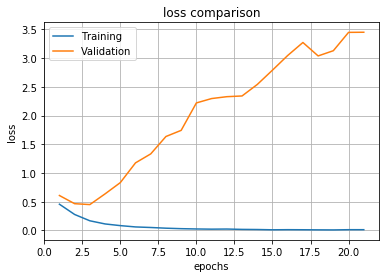

In [0]:
model, stats = task.train(100, train_loader, valid_loader, freq, out_dir)

### Evaluate

In [0]:
# # To test a saved model
# task.model.load(os.path.join(out_dir, 'model_epoch_95.pkl'))

In [0]:
# Testing
f1_test = task.evaluate(test_loader, verbose=True)
print('F1 score: ', f1_test)

Confusion Matrix: 
 [[10196  2304]
 [ 1982 10518]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     12500
         1.0       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

F1 score:  (0.8307400679251243, 3.1347351652817053)
